In [1]:
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

## HW 3, Q2 gibbs sampler

In [19]:
#running gibbs sampler
alpha = 2
lambd = 2


theta_not = 2
tau_not = 2

n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)

C,G = 2,1000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = stats.norm(theta_not,tau_not).rvs(1) # initialization
tau[:,0] = stats.gamma(alpha,lambd).rvs(1)
for c in range(C):
    for g in range(1,G):
        tau[c,g] = stats.gamma(a = (alpha+n)/2, scale = 2/((((x-theta[c,g-1])**2).sum()) + lambd)).rvs()
        theta[c,g] = stats.norm(loc=(tau[c,g]*n*np.average(x) + tau_not*theta_not)/(n*tau[c,g] + tau_not), scale = (1/(n*tau[c,g]+tau_not))).rvs()

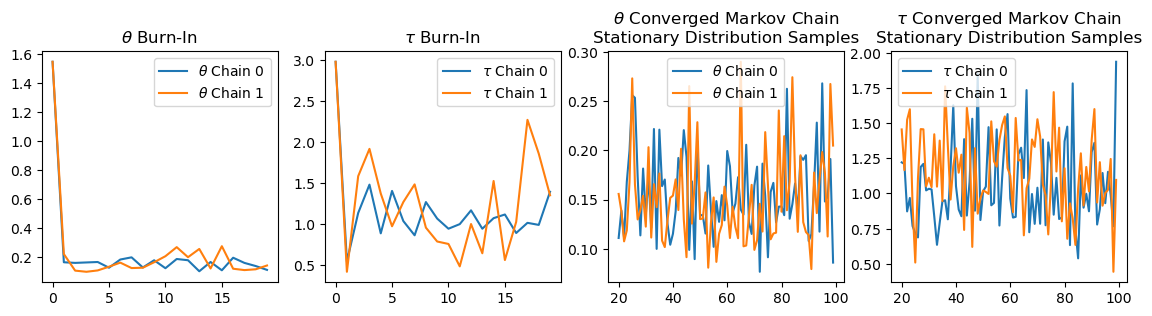

In [20]:
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 20
demo = 100
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();         

array([0.08313775, 0.25475866])

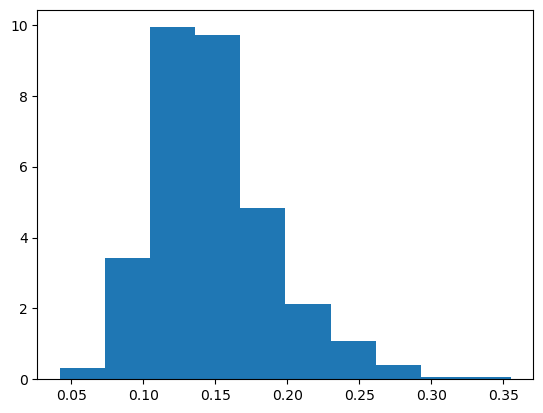

In [21]:
plt.hist(theta[1,burn:], density = True)
np.quantile(theta[1], [0.025,0.975])

array([0.66226803, 1.7653074 ])

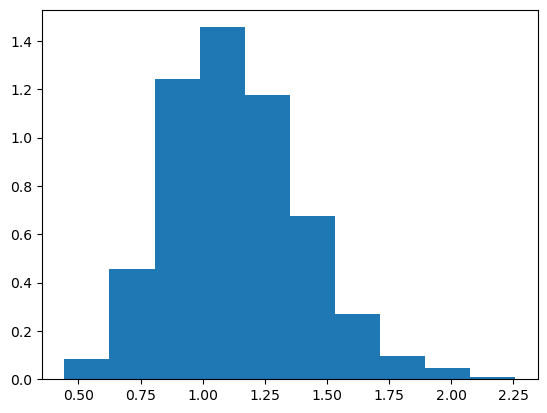

In [22]:
plt.hist(tau[1,burn:], density = True)
np.quantile(tau[1], [0.025,0.975])

# Q1

In [31]:
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,1000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = stats.norm(2,2).rvs(1)  # initialization
tau[:,0] = stats.gamma(2,2).rvs(1)
for c in range(C):
    for g in range(1,G):
        # https://en.wikipedia.org/wiki/Gamma_distribution
        
        #as a functon of tau, the likelihood * prior of tau is proportional to the joint
        #p_tau_given_all_target
        tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c,g-1],scale=1/(tau_)**0.5).pdf(x))*\
        stats.gamma(2, 2).pdf(tau_) #tau prior is the gamma distribution
        
        tau_proposal = stats.expon(scale = 2)
        tau_tilde = tau_proposal.rvs()
        
        mh_calc = (tau_target(tau_tilde)/tau_target(tau[c,g-1]))*(tau_proposal.pdf(tau[c,g-1])/tau_proposal.pdf(tau_tilde))
        
        acceptance_probability = min(1,mh_calc)
        
        
        if stats.uniform().rvs() < acceptance_probability:
            tau[c,g] = tau_tilde
        else:
            tau[c,g] = tau[c,g-1]
        
        theta_target = lambda theta_: np.prod(stats.norm(loc=theta_,scale=1/(tau[c,g-1])**0.5).pdf(x))*\
        stats.norm(loc=2, scale = 2).pdf(theta_)
        
        theta_proposal = stats.expon(scale=2)
        theta_tilde = theta_proposal.rvs()
        
        mh_calc_theta = (theta_target(theta_tilde)/theta_target(theta[c,g-1]))*(theta_proposal.pdf(theta[c,g-1])/theta_proposal.pdf(theta_tilde))
        
        acceptance_probability_theta = min(1,mh_calc_theta)
        
        
        if stats.uniform().rvs() < acceptance_probability_theta:
            theta[c,g] = theta_tilde
        else:
            theta[c,g] = theta[c,g-1]
        
        
        
        
        #tau[c,g] = joint * prior_tau
        #theta[c,g] = joint * prior_theta

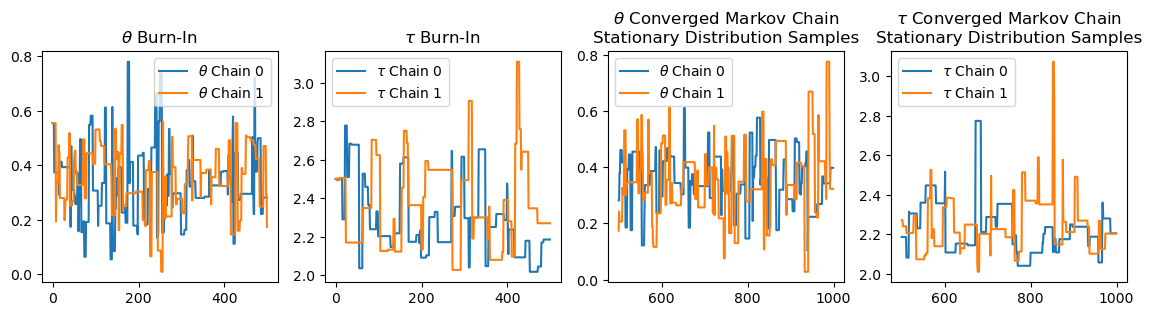

In [32]:
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 500
demo = 1000
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();         

array([0.08691933, 0.58553605])

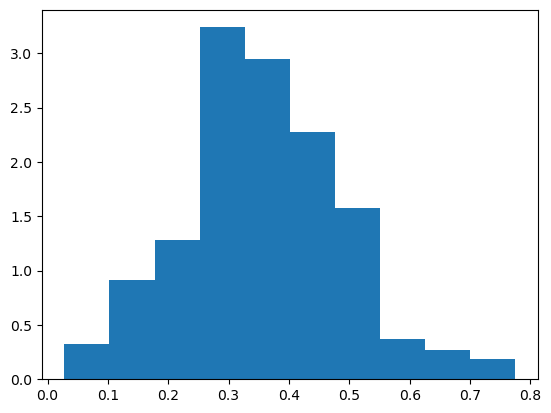

In [33]:
#inference
plt.hist(theta[1,burn:], density = True)
np.quantile(theta[1], [0.025,0.975])

there is a 97.5% probability that the true value of theta lies between 0.087 and 0.586

array([2.06476513, 2.75097966])

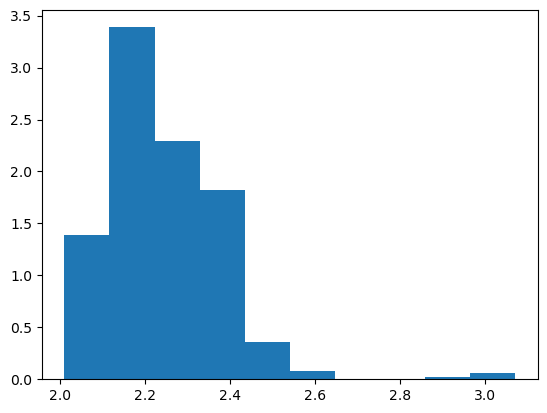

In [34]:
plt.hist(tau[1,burn:], density = True)
np.quantile(tau[1], [0.025,0.975])

There is a 97.5% probability that the true value of Tau lies between 2.065 and 2.75

**Comparison of samplers**

In this updated Gibbs sampler, we have used the metropolis hastings algorithm to sample from the full conditional distributions of Tau and Theta, given that we do not know what the form of the joint distribution is. This is in contrast to our previous gibbs sampler where computed the joint distributions and sampled directly from there.

Our target distribution for Tau is nothing but the product of our joint normal likelihood with the gamma prior. To explore this distributon we used an exponential proposal distribution. This restricts the Tau to only positive values. An exponential distribution is similar in form to the gamma prior and was chosen on that basis. When we compare the results from our original gibbs to this new one, our original gibbs converged at a smaller value, between 1 and 1.25. Our updated gibbs gives a slightly different result, converging at around 2.2. This is interesting, as it suggests that the transition distribution we sample from deviates slightly from the target joint distribution. This is expected since a proposal distribution is an approximation of the target. If we increased the number of iterations to 10,000, perhaps the two histograms of the two gibbs samplers would look more similar.

Our target distribution for Theta is the product of our joint normal likelihood with the normal prior. To explore this distributon we again used an exponential proposal distribution. When we compare our results, our previous gibbs sampler converges to around 0.15 while our new gibbs sampler converges to around 0.3. Again, the histograms for both are similar but the modes are different (albeit not by a lot). This is similar to our result for the Tau distribution. The likely explanation ,again, is that the MH algorithm gives an estimate which is bound to have some error term in estimating the target. Thus, if n is much higher and if we have a better proposal distribution, the two gibbs samplers may yield the same result.

It is important to note that our MH gibbs samplers are 'jumpy' wherein the value of theta and tau jump across the parameter space. This could be due to the high variance of our exponential distribution which is '4'. This could lead to a high rejection rate, and so we must account for this. 


## Q2

In [46]:
n = 30; x = stats.norm(loc=0, scale=1).rvs(size=n)
C,G = 2,1000  # chains, Gibbs samples
theta,tau = np.zeros([C,G]),np.zeros([C,G])
theta[:,0] = stats.norm(2,2).rvs(1)  # initialization
tau[:,0] = stats.gamma(2,2).rvs(1)
for c in range(C):
    for g in range(1,G):
        # https://en.wikipedia.org/wiki/Gamma_distribution
        
        #as a functon of tau, the likelihood * prior of tau is proportional to the joint
        #p_tau_given_all_target
        tau_target = lambda tau_: np.prod(stats.norm(loc=theta[c,g-1],scale=1/(tau_)**0.5).pdf(x))*\
        stats.gamma(2, 2).pdf(tau_) #tau prior is the gamma distribution
        
        
        tau_proposal = stats.truncnorm(a=-tau[c,g-1]/0.05, b=np.inf,loc=tau[c,g-1], scale=0.05)
        tau_tilde = tau_proposal.rvs()
        
        mh_calc = (tau_target(tau_tilde)/tau_target(tau[c,g-1]))*(tau_proposal.pdf(tau[c,g-1])/tau_proposal.pdf(tau_tilde))
        
        acceptance_probability = min(1,mh_calc)
        
        
        if stats.uniform().rvs() < acceptance_probability:
            tau[c,g] = tau_tilde
        else:
            tau[c,g] = tau[c,g-1]
        
        theta_target = lambda theta_: np.prod(stats.norm(loc=theta_,scale=1/(tau[c,g-1])**0.5).pdf(x))*\
        stats.norm(loc=2, scale = 2).pdf(theta_)
        
        theta_proposal = stats.halfnorm(2)
        theta_tilde = theta_proposal.rvs()
        
        mh_calc_theta = (theta_target(theta_tilde)/theta_target(theta[c,g-1]))*(theta_proposal.pdf(theta[c,g-1])/theta_proposal.pdf(theta_tilde))
        
        acceptance_probability_theta = min(1,mh_calc_theta)
        
        
        if stats.uniform().rvs() < acceptance_probability_theta:
            theta[c,g] = theta_tilde
        else:
            theta[c,g] = theta[c,g-1]

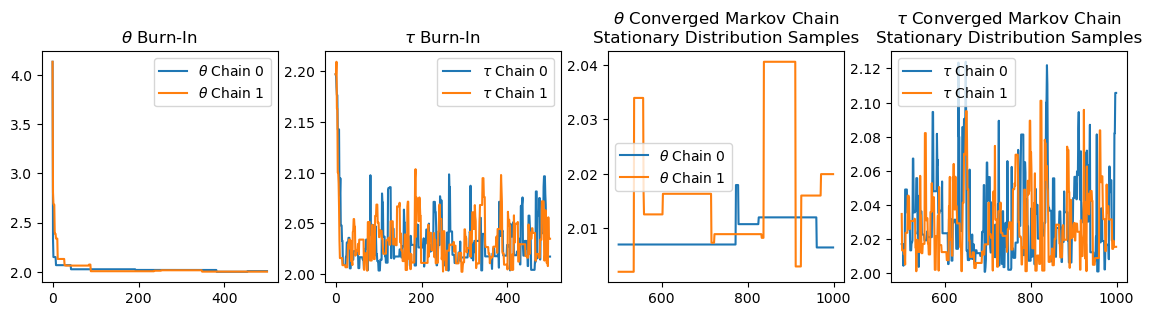

In [47]:
fig,ax = plt.subplots(1, 4, figsize=(14,3)); ax[0].set_title("$\\theta$ Burn-In"); ax[1].set_title("$\\tau$ Burn-In"); ax[2].set_title("$\\theta$ Converged Markov Chain\nStationary Distribution Samples"); ax[3].set_title("$\\tau$ Converged Markov Chain\nStationary Distribution Samples")
burn = 500
demo = 1000
for c in range(C):
    ax[0].plot(theta[c,:burn], label="$\\theta$ Chain "+str(c))
    ax[1].plot(tau[c,:burn], label="$\\tau$ Chain "+str(c))
    ax[2].plot(np.arange(burn, demo, dtype=int), theta[c,burn:demo], label="$\\theta$ Chain "+str(c))
    ax[3].plot(np.arange(burn, demo, dtype=int), tau[c,burn:demo], label="$\\tau$ Chain "+str(c))
ax[0].legend(); ax[1].legend(); ax[2].legend(); ax[3].legend();         

array([2.00195131, 2.13028276])

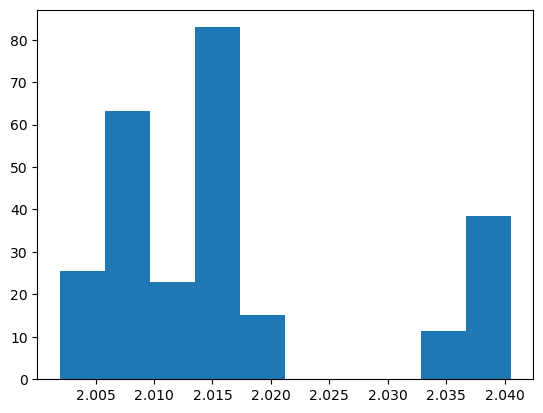

In [48]:
plt.hist(theta[1,burn:], density = True)
np.quantile(theta[1], [0.025,0.975])

There is a 97.5% probability that the true value of Theta lies between 2 and 2.13

array([2.00211691, 2.08218049])

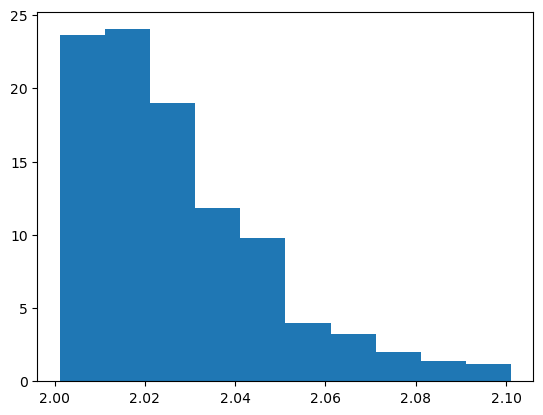

In [49]:
plt.hist(tau[1,burn:], density = True)
np.quantile(tau[1], [0.025,0.975])

There is a 97.5% probability that the true value of Tau lies between 2 and 2.08

analytically determining the full conditionals has its merit as the gibbs samplers that relied on the MH algorithm came close, but did not exactly model the histograms created by the original gibbs sampler. If computational power and sample size(n) is not an issue, analytically determining the full conditional is not required. If the full conditional is tractable, then it should be used directly by all means. 

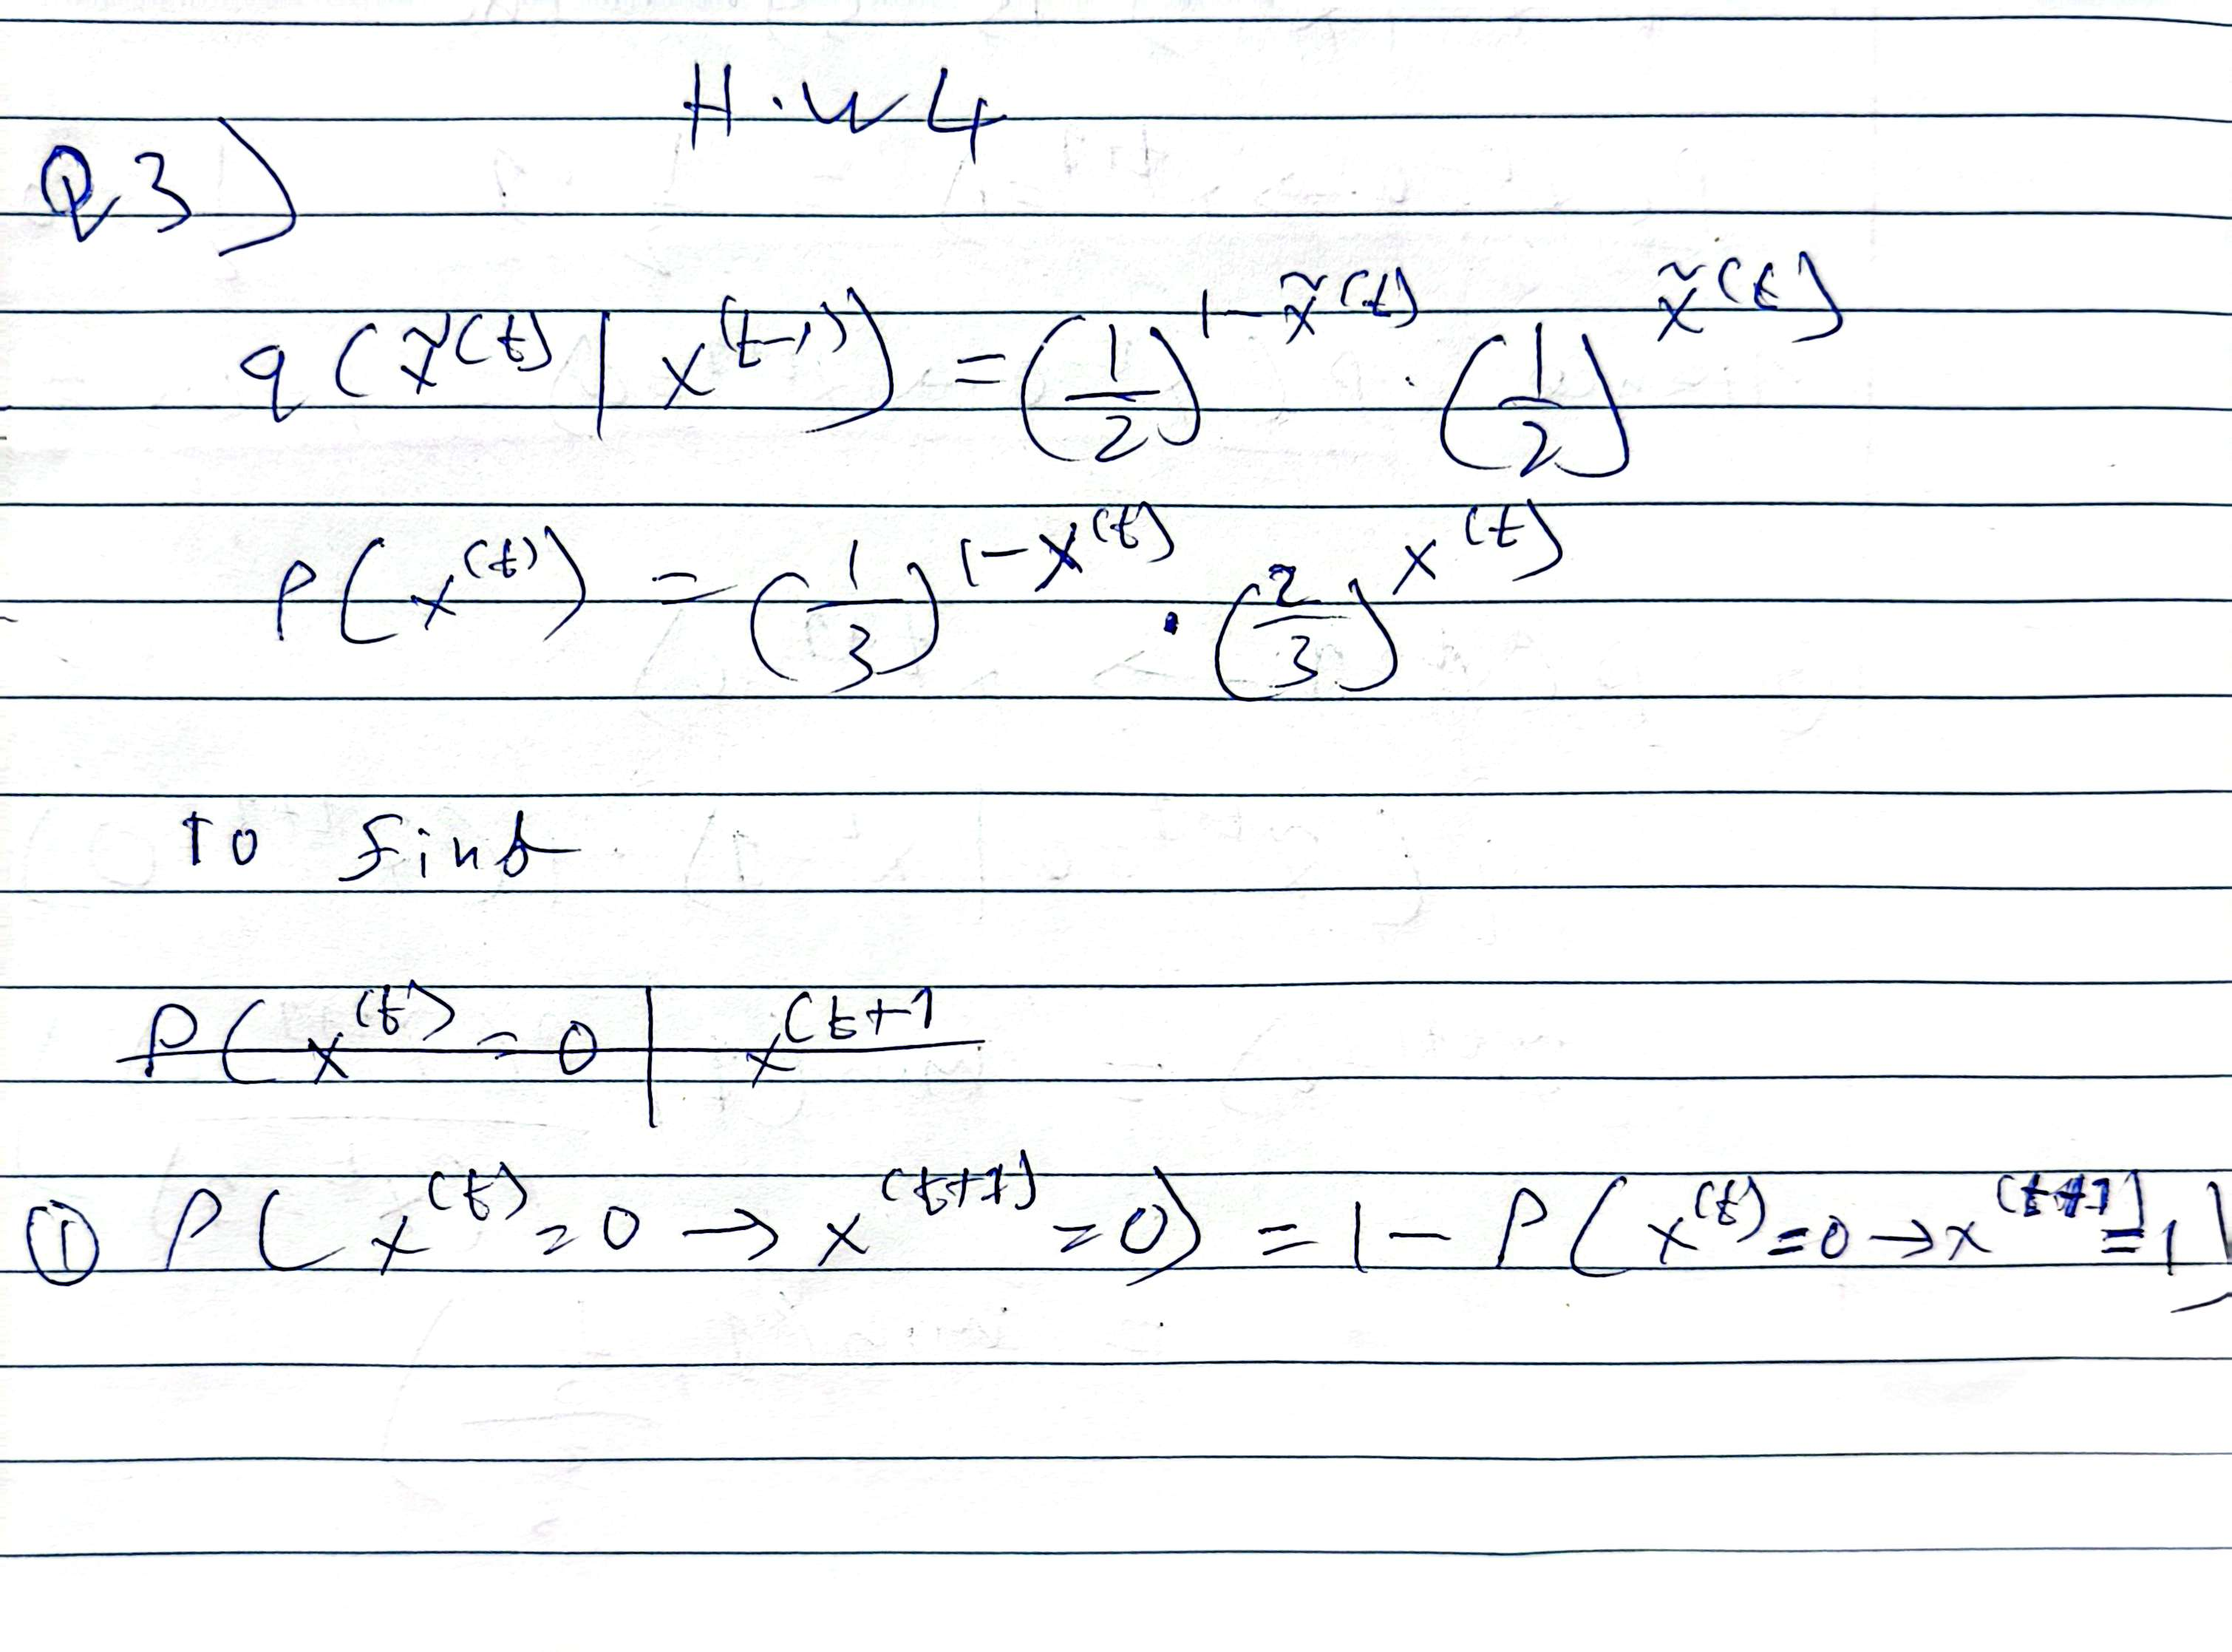

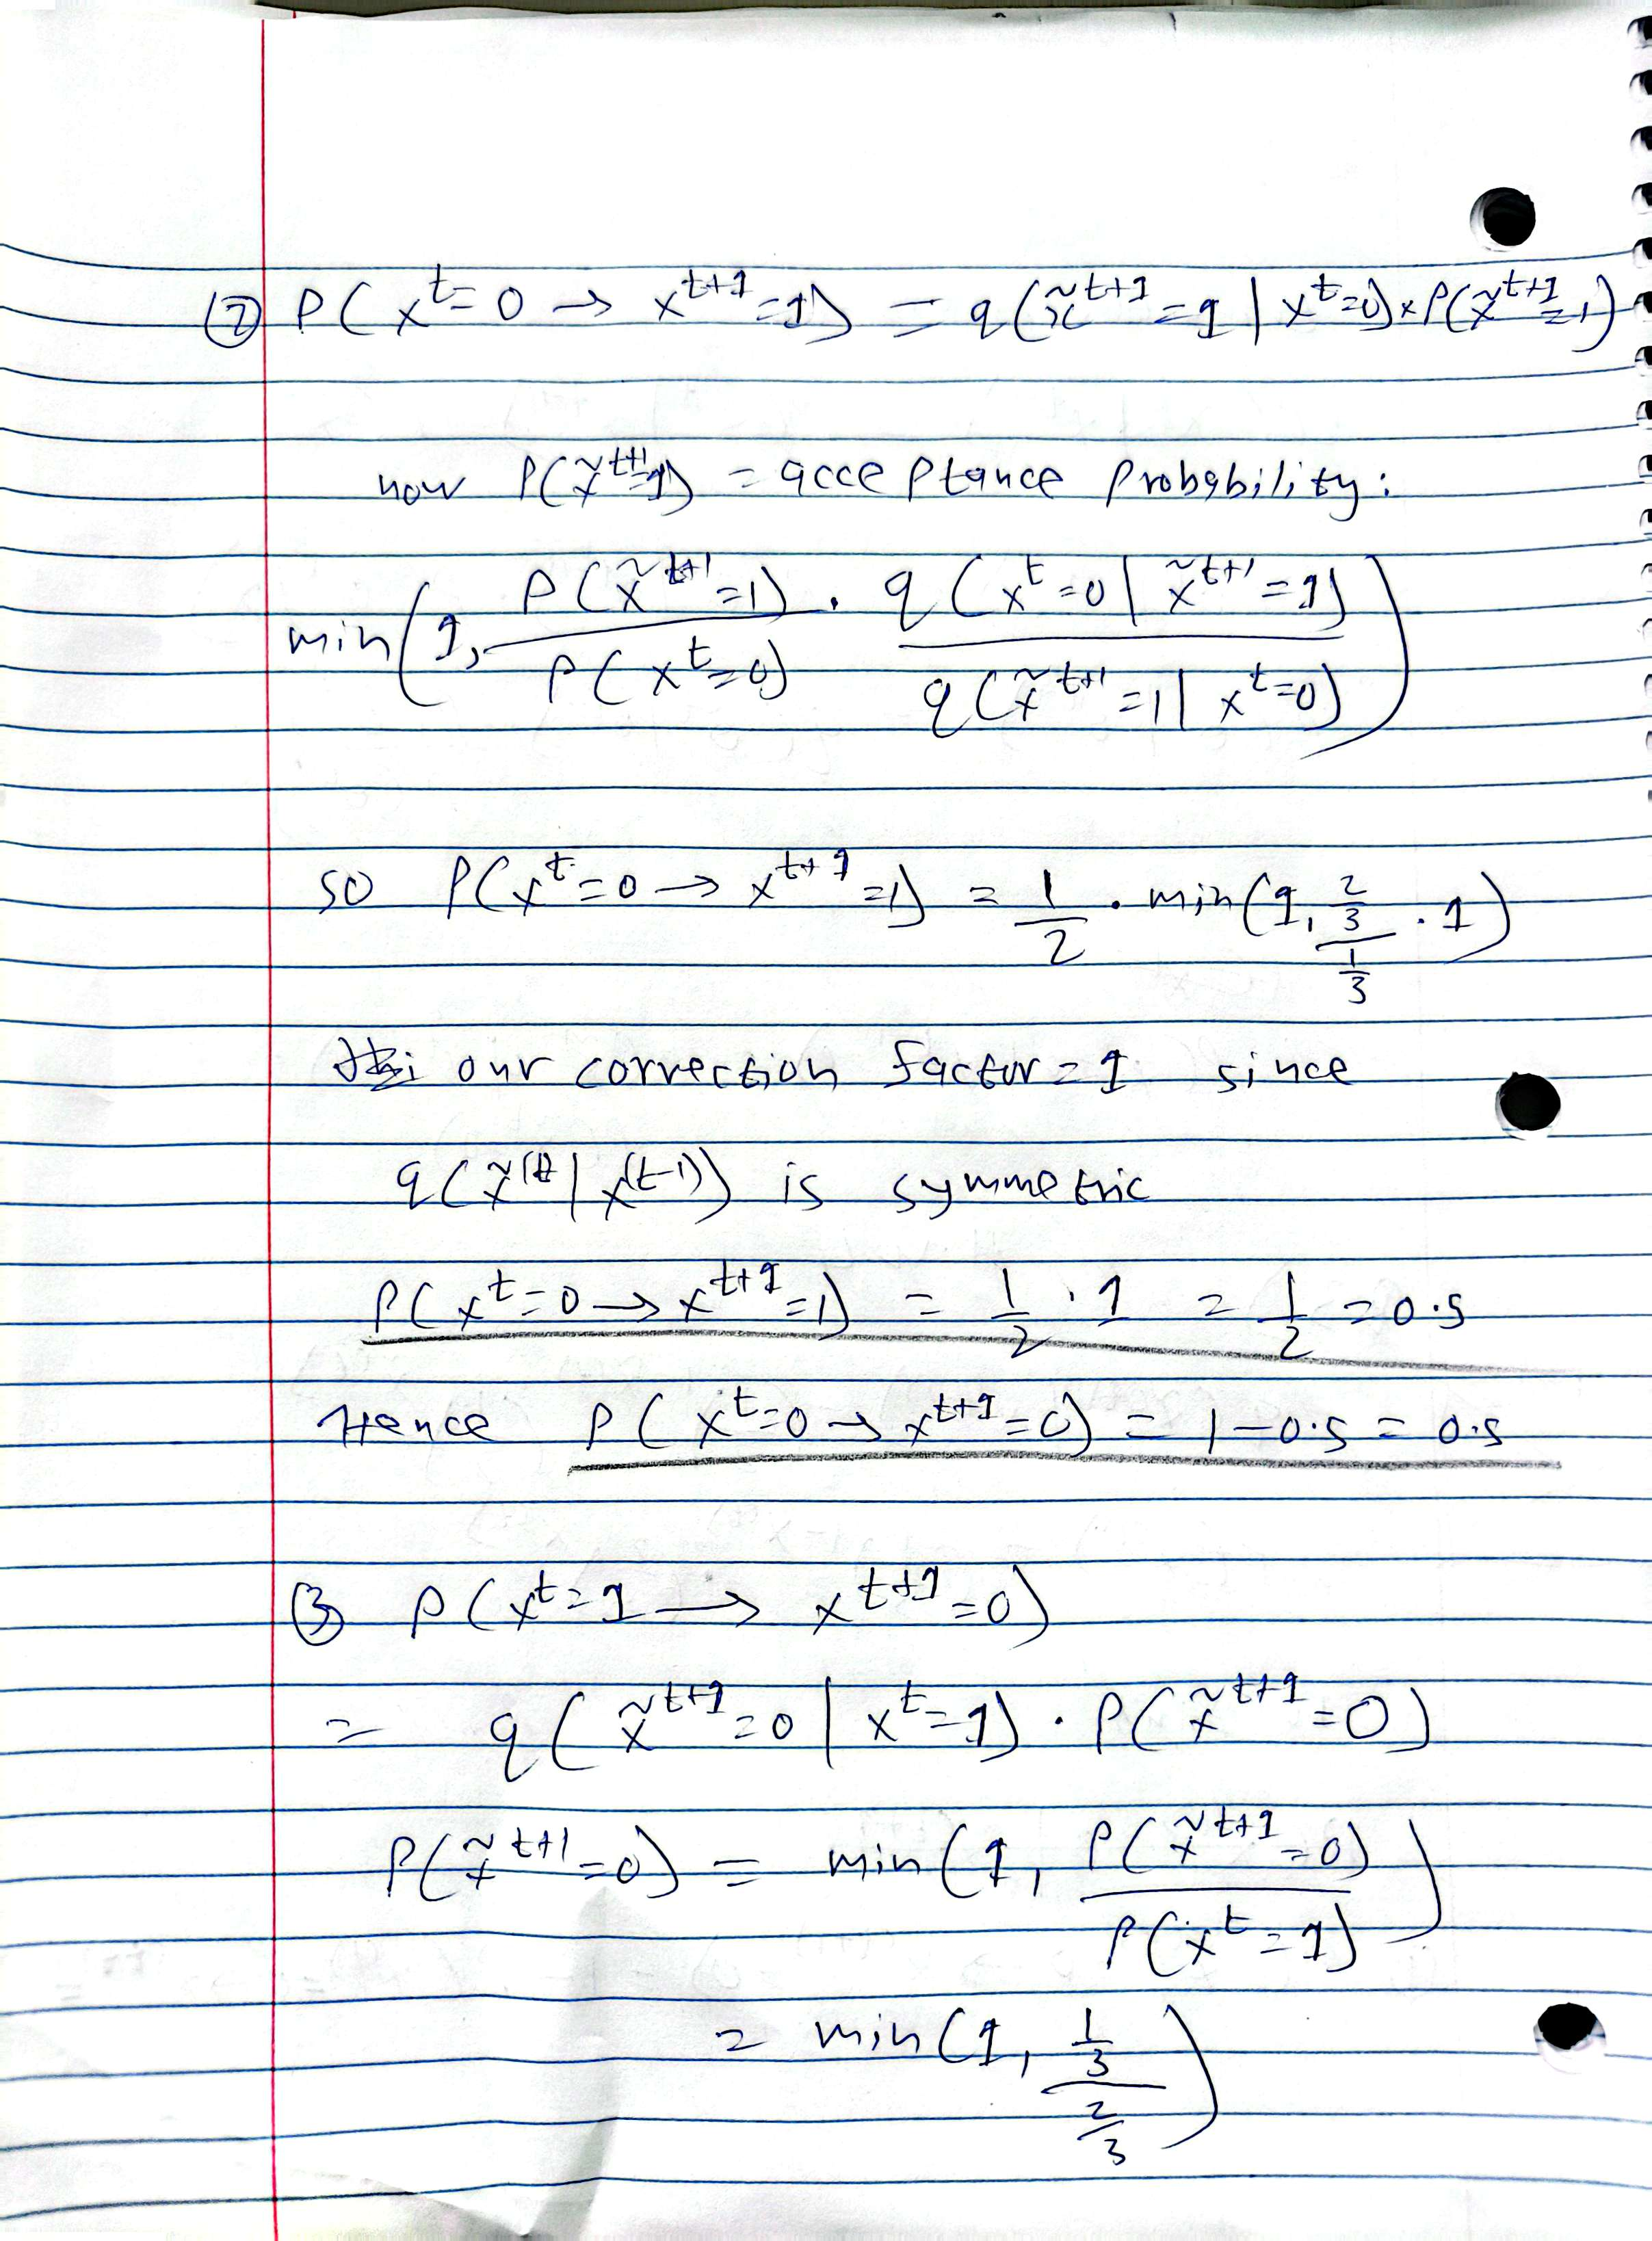

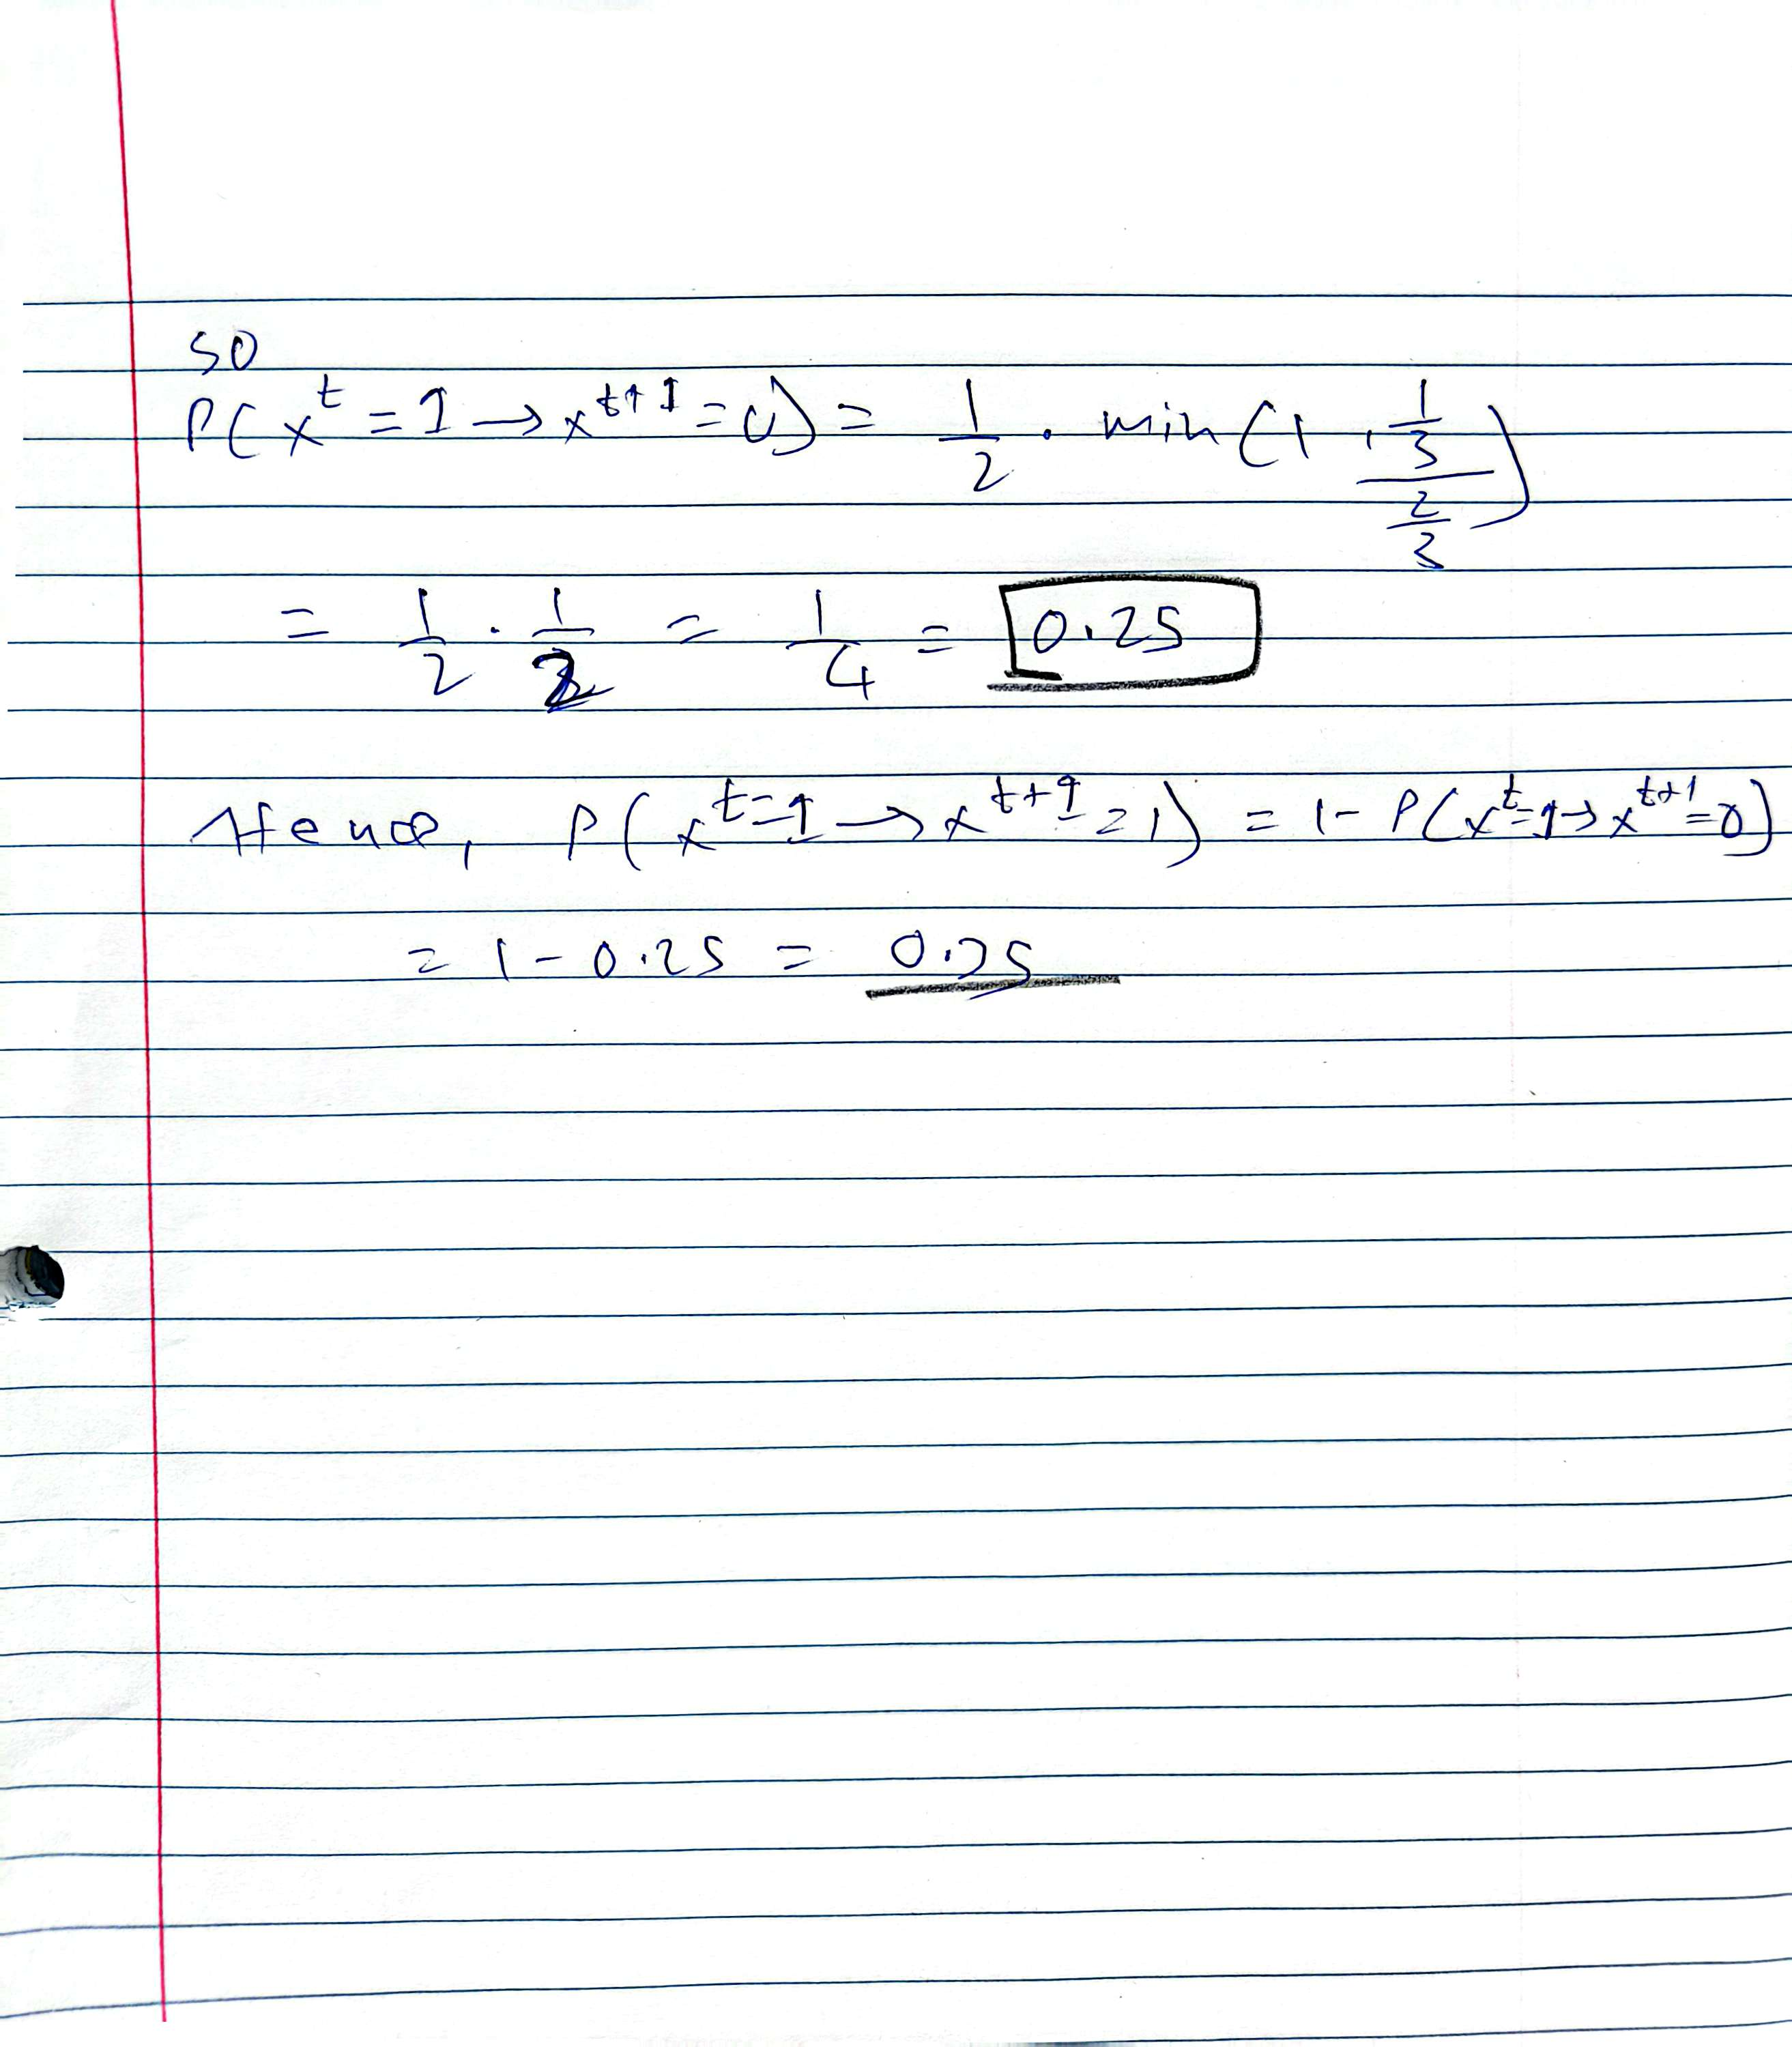